# Node elevations and edge grades

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Documentation](https://osmnx.readthedocs.io/)
  - [Journal article and citation info](https://doi.org/10.1111/gean.70009)
  - [Code repository](https://github.com/gboeing/osmnx)
  - [Examples gallery](https://github.com/gboeing/osmnx-examples)

OSMnx allows you to automatically add elevation attributes to your graph's nodes with the `elevation` module, using either local raster files or the Google Maps Elevation API as the elevation data source. If you use the Google API, you will need an API key. Once your nodes have elevation values, OSMnx can automatically calculate your edges' grades (inclines).

In [31]:
import sys

import numpy as np
import osmnx as ox
import pandas as pd

ox.__version__

'2.0.3'

## Elevation from local raster file(s)

OSMnx can attach elevations to graph nodes using either a single raster file or a list of raster files. The latter creates a virtual raster VRT composed of the rasters at those filepaths. By default, it uses all available CPUs but you can configure this with an argument.

In [32]:
address = "600 Montgomery St, San Francisco, California, USA"
G = ox.graph.graph_from_address(address=address, dist=500, dist_type="bbox", network_type="all")

In [33]:
# add node elevations from a single raster file
# some nodes will be null because the single file does not cover the graph's extents
raster_path = "elevation1.tif"
try:
    G = ox.elevation.add_node_elevations_raster(G, raster_path, cpus=1)
except Exception as e:
    print(f"Could not load raster file '{raster_path}': {e}")

In [34]:
# add node elevations from multiple raster files
# no nulls should remain
raster_paths = ["elevation1.tif", "elevation2.tif"]
G = ox.elevation.add_node_elevations_raster(G, raster_paths, cpus=1)
assert not np.isnan(np.array(G.nodes(data="elevation"))[:, 1]).any()

In [35]:
# add edge grades and their absolute values
G = ox.elevation.add_edge_grades(G, add_absolute=True)

## Elevation from Google Maps Elevation API

You will need a Google Maps Elevation [API key](https://developers.google.com/maps/documentation/elevation/start). Remember to track your API usage and costs. If you don't want to set up a Google Maps API key, you could use a free alternative web service that provides the same interface, such as [Open Topo Data](https://www.opentopodata.org/) which doesn't require an API key. Note that there is some spatial inaccuracy in elevation data resolution. For example, in San Francisco (where Google's resolution is ~19 meters) a couple of edges in hilly parks have a 50+ percent grade because Google assigns one of their nodes the elevation of a hill adjacent to the street.

## Calculate some summary stats

Use an undirected representation of the network so we don't overcount two-way streets (because they have reciprocal edges pointing in each direction). We use the absolute value of edge grade because we're interested in steepness, not directionality.

In [36]:
# calculate the edges' absolute grades (and drop any infinite/null values)
grades = pd.Series([d["grade_abs"] for _, _, d in ox.convert.to_undirected(G).edges(data=True)])
grades = grades.replace([np.inf, -np.inf], np.nan).dropna()

In [37]:
avg_grade = np.mean(grades)
print(f"Average street grade is {avg_grade * 100:.1f}%")

med_grade = np.median(grades)
print(f"Median street grade in is {med_grade * 100:.1f}%")

Average street grade is 22.9%
Median street grade in is 3.7%


## Plot the nodes by elevation

Plot them colored from low (violet) to high (yellow).

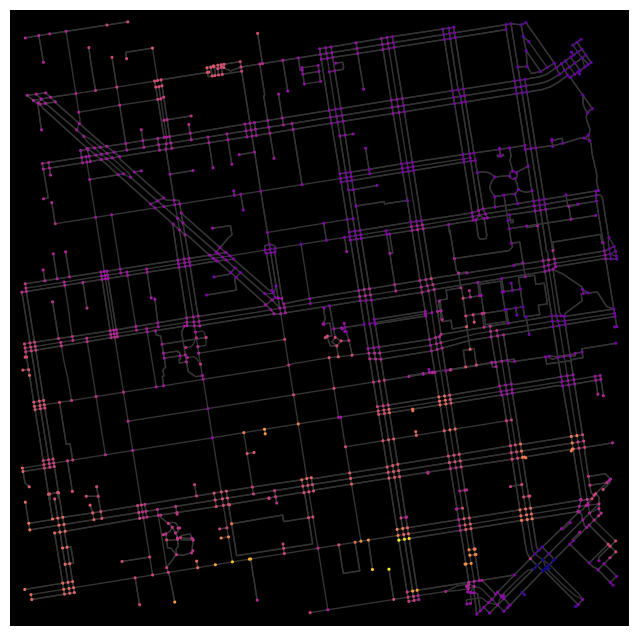

In [38]:
# get one color for each node, by elevation, then plot the network
nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
fig, ax = ox.plot.plot_graph(G, node_color=nc, node_size=5, edge_color="#333333", bgcolor="k")

## Plot the edges by grade

Grade is the ratio of elevation change to edge length. Plot edges colored from low/flat (violet) to high/steep (yellow).

       23.000112718572794],
      dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg
Falling back to equal_size=False.


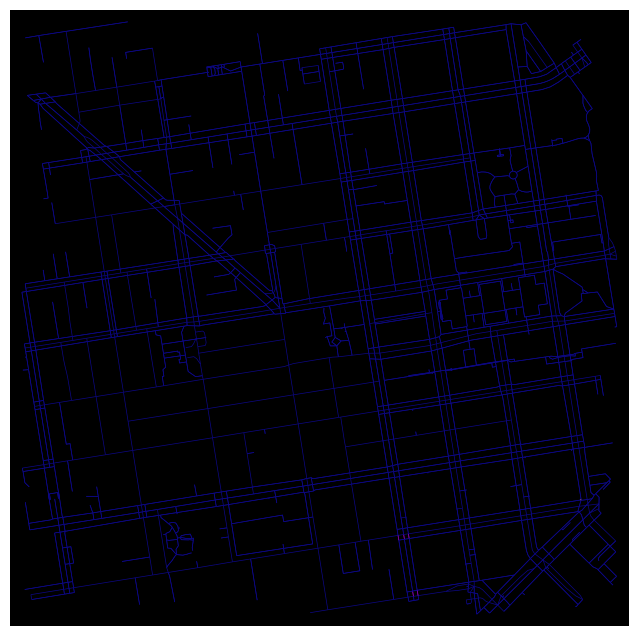

In [39]:
# get a color for each edge, by grade, then plot the network
try:
    ec = ox.plot.get_edge_colors_by_attr(
        G, "grade_abs", cmap="plasma", num_bins=5, equal_size=True
    )
except ValueError as e:
    print(f"Warning: {e}\nFalling back to equal_size=False.")
    ec = ox.plot.get_edge_colors_by_attr(
        G, "grade_abs", cmap="plasma", num_bins=5, equal_size=False
    )
fig, ax = ox.plot.plot_graph(G, edge_color=ec, edge_linewidth=0.5, node_size=0, bgcolor="k")

## Calculate shortest paths, considering grade impedance

This example approximates the route of "The Wiggle" in San Francisco.

In [40]:
# select an origin and destination node and a bounding box around them
origin = ox.distance.nearest_nodes(G, -122.426, 37.77)
destination = ox.distance.nearest_nodes(G, -122.441, 37.773)
bbox = ox.utils_geo.bbox_from_point((37.772, -122.434), dist=1500)

In [41]:
# define some edge impedance function here


def impedance(length, grade):
    penalty = grade**2
    return length * penalty


# add impedance and elevation rise values to each edge in the projected graph
# use absolute value of grade in impedance function if you want to avoid uphill and downhill
for _, _, _, data in G.edges(keys=True, data=True):
    data["impedance"] = impedance(data["length"], data["grade_abs"])
    data["rise"] = data["length"] * data["grade"]

#### First find the shortest path that minimizes *trip distance*:

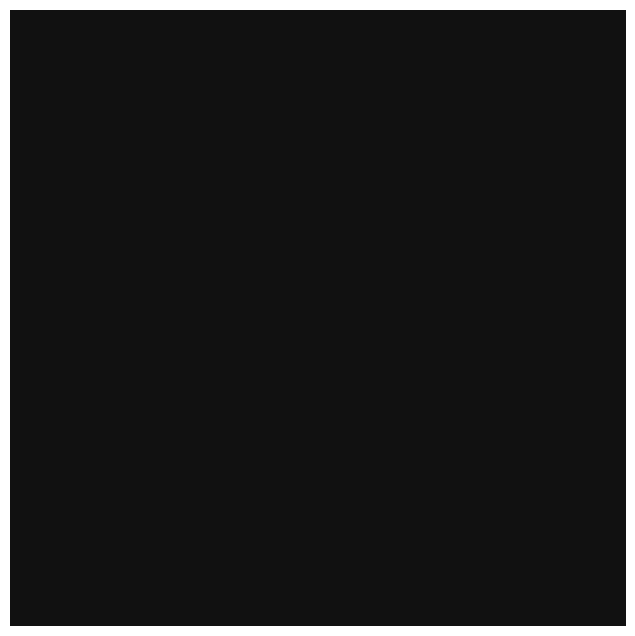

In [42]:
route_by_length = ox.routing.shortest_path(G, origin, destination, weight="length")
fig, ax = ox.plot.plot_graph_route(G, route_by_length, bbox=bbox, node_size=0)

#### Now find the shortest path that avoids slopes by minimizing *impedance* (function of length and grade):

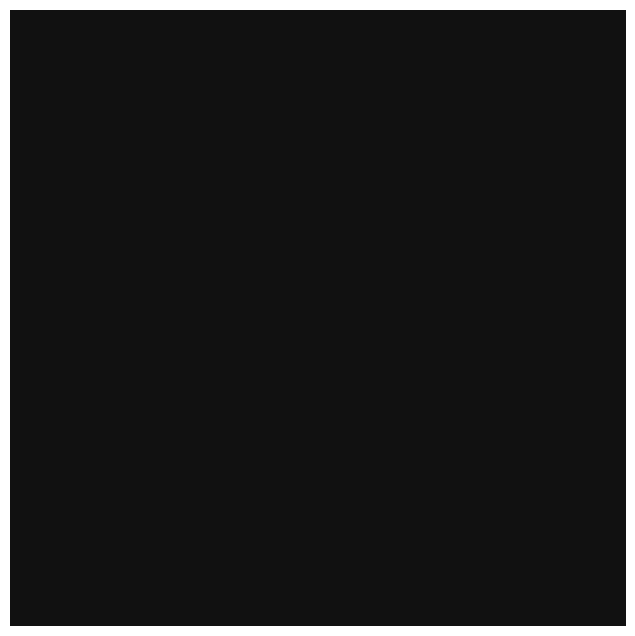

In [43]:
route_by_impedance = ox.routing.shortest_path(G, origin, destination, weight="impedance")
fig, ax = ox.plot.plot_graph_route(G, route_by_impedance, bbox=bbox, node_size=0)

#### Print some summary stats about these two routes:

In [44]:
def print_route_stats(route):
    route_grades = ox.routing.route_to_gdf(G, route, weight="grade_abs")["grade_abs"]
    msg = "The average grade is {:.1f}% and the max is {:.1f}%"
    print(msg.format(np.mean(route_grades) * 100, np.max(route_grades) * 100))

    route_rises = ox.routing.route_to_gdf(G, route, weight="rise")["rise"]
    ascent = np.sum([rise for rise in route_rises if rise >= 0])
    descent = np.sum([rise for rise in route_rises if rise < 0])
    msg = "Total elevation change is {:.1f} meters: {:.0f} meter ascent and {:.0f} meter descent"
    print(msg.format(np.sum(route_rises), ascent, abs(descent)))

    route_lengths = ox.routing.route_to_gdf(G, route, weight="length")["length"]
    print(f"Total trip distance: {np.sum(route_lengths):,.0f} meters")

So, we decreased the average slope along the route from a 5% grade to a 2% grade. The total elevation change is obviously (approximately, due to rounding) the same with either route, but using our impedance function we decrease the total ascent from 69 meters to 42 meters (but the trip distance increases from 1.9 km to 3.3 km).

### Steepness Belgium test

In [4]:
# Download the street network for Belgium (this may be very large and resource-intensive!)
belgium_address = "Belgium"
G_belgium = ox.graph.graph_from_place(belgium_address, network_type="highway", simplify=True)

NameError: name 'ox' is not defined

In [46]:
# Save G_belgium to disk (GraphML format)
ox.save_graphml(G_belgium, filepath="belgium_graph.graphml")

In [47]:
# Load G_belgium from disk
G_belgium_loaded = ox.load_graphml(filepath="belgium_graph.graphml")

In [ ]:
# Add node elevations from raster files (replace with your Belgium DEM files)
belgium_raster_paths = ["DTM_20m.tif"]
try:
    G_belgium = ox.elevation.add_node_elevations_raster(G_belgium, belgium_raster_paths, cpus=1)
except Exception as e:
    print(f"Could not load Belgium raster files: {e}")

Could not load Belgium raster files: 'float' object is not iterable


In [ ]:
# Add edge grades and their absolute values
G_belgium = ox.elevation.add_edge_grades(G_belgium, add_absolute=True)

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [ ]:
# Get a color for each edge by grade, then plot the network
try:
    ec_belgium = ox.plot.get_edge_colors_by_attr(
        G_belgium, "grade_abs", cmap="plasma", num_bins=5, equal_size=True
    )
except ValueError as e:
    print(f"Warning: {e}\nFalling back to equal_size=False.")
    ec_belgium = ox.plot.get_edge_colors_by_attr(
        G_belgium, "grade_abs", cmap="plasma", num_bins=5, equal_size=False
    )
fig, ax = ox.plot.plot_graph(G_belgium, edge_color=ec_belgium, edge_linewidth=0.5, node_size=0, bgcolor="k")